# 1. Sparkify Project Workspace

This is done based on the analysis with Pandas. So some detailed steps are ommited here.

In [34]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
% matplotlib inline
import seaborn as sns

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import functions as F

import datetime

In [35]:
# create a Spark session
configure = SparkConf().setAppName("sparkify").setMaster("local")
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-d5afc86b-deb0-40c5-94fd-816cf79fab75',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'zqjpHOLfNDmE0XMLvegLN0_DWFI_BDeSIQLQhDvCb9wI'
}

configuration_name = 'os_8bfcc3c030124734958972b41a36cec1_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# 2. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
df_total = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-gkwqpiyvqhelzl'))
df_total.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [3]:
# backup dataframe
df_total_backup = df_total

## 2.1 Remove undesired columns

Following columns are removed:

- **`artist`**, **`song`** and **`location`**

    The behaviour of a R&B fan and a classic music lover can certainly be different. But considering this variance requirs a    database with labeled artists and songs, which is beyond the scope of this project. 

    Similarly, user from different locations may also behaviour differenetly related with for example the local personal income level. This feature is also left for investigation in future.  
    

- **`firstName`** and **`lastName`**

    They are not related with user behaviour.
    

- **`itemInSession`**, **`method`**, **`sessionId`**, **`status`**

    These parameters are simply technical parameters. They are not related with user behaviour.

In [4]:
df_total = df_total.drop('artist','song','location','firstName','lastName','itemInSession','method','sessionId','status')

In [5]:
df_total.take(1)

[Row(auth='Logged In', gender='M', length=597.55057, level='free', page='NextSong', registration=1532063507000, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

## 2.2 Understanding and clean the data 

### 2.2.1 Overview

In [6]:
df_total.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df_total.describe().collect()

[Row(summary='count', auth='543705', gender='528005', length='432877', level='543705', page='543705', registration='528005', ts='543705', userAgent='528005', userId='543705'),
 Row(summary='mean', auth=None, gender=None, length='248.66459278007738', level=None, page=None, registration='1.535523414862437E12', ts='1.5409645412098003E12', userAgent=None, userId='60268.42669103512'),
 Row(summary='stddev', auth=None, gender=None, length='98.41266955051972', level=None, page=None, registration='3.0787254929957166E9', ts='1.4820571449105084E9', userAgent=None, userId='109898.82324176628'),
 Row(summary='min', auth='Cancelled', gender='F', length='0.78322', level='free', page='About', registration='1509854193000', ts='1538352011000', userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.3 (KHTML, like Gecko) Version/8.0 Safari/600.1.3"', userId=''),
 Row(summary='max', auth='Logged Out', gender='M', length='3024.66567', level='paid', page='Upgrade', registration='1543073

In [8]:
print(df_total.where(df_total.gender.isNull()).count())
print(df_total.where(df_total.length.isNull()).count())
print(df_total.where(df_total.registration.isNull()).count())
print(df_total.where(df_total.userAgent.isNull()).count())

15700
110828
15700
15700


They are all referring to unregistered users, see the results below.

In [9]:
df_total[df_total.userId == ''].count()

15700

Those columns are removed. Statistics of the dataframe with remaining columns is shown below:

In [10]:
df_total = df_total[df_total.userId != '']

### 2.2.3 Clean Column `auth`

Unique values of `auth`:

In [11]:
df_total = df_total.drop('auth')

### 2.2.4. Column `gender`

In [12]:
# check against null 
df_total.select('gender').distinct().collect()

[Row(gender='F'), Row(gender='M')]

There is no empty value. It will be transformed to numeric value using OneHotEnconder later.

### 2.2.5 Clean Column `length`

When not visiting page 'Next song', the value `length` is null. These nulls are as expected, so they are "right" nulls, and do not require removing or imputing. 

In [13]:
df_total.select('length','page').where(df_total.length.isNull()).groupBy('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   99|
|    Submit Downgrade|  117|
|         Thumbs Down| 4911|
|                Home|19089|
|           Downgrade| 3811|
|         Roll Advert| 7773|
|              Logout| 5990|
|       Save Settings|  585|
|Cancellation Conf...|   99|
|               About| 1026|
|            Settings| 2964|
|     Add to Playlist|12349|
|          Add Friend| 8087|
|           Thumbs Up|23826|
|                Help| 2644|
|             Upgrade|  968|
|               Error|  503|
|      Submit Upgrade|  287|
+--------------------+-----+



### 2.2.6 Clean Column `level`

In [14]:
# check against null
df_total.where(df_total.level.isNull()).count()

0

This column has no nulls now. It is used to generate the UBC.

### 2.2.7 Clean column `page`

Unique values:

In [16]:
list(df_total.select('page').distinct().toPandas().page.values)

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

### 2.2.8 clean column `registration`, 2.2.9 clean column `ts`

I leave these two columns as they are to save computation cost. After all, I only care about the difference. 

### 2.2.10 clean column `userAgent`

I devide the values into three groups:

- when it contains 'Windows', then it is category w
- when it contains 'Linux', then it is category l
- the rest are category m (ios, mac etc.)

For this purpose, a function is defined: 

In [19]:
function = udf(lambda x: 'w' if 'Windows' in x else 'l' if 'Linux' in x else 'm')

In [20]:
df_total = df_total.withColumn('userAgentNew', function('userAgent'))

In [21]:
df_total.show(1)

+------+---------+-----+--------+-------------+-------------+--------------------+------+------------+
|gender|   length|level|    page| registration|           ts|           userAgent|userId|userAgentNew|
+------+---------+-----+--------+-------------+-------------+--------------------+------+------------+
|     M|597.55057| free|NextSong|1532063507000|1538352011000|"Mozilla/5.0 (Mac...|   293|           m|
+------+---------+-----+--------+-------------+-------------+--------------------+------+------------+
only showing top 1 row



In [22]:
df_total = df_total.drop('userAgent')
df_total.select('userAgentNew').distinct().show()

+------------+
|userAgentNew|
+------------+
|           l|
|           m|
|           w|
+------------+



### 2.2.11 clean column `userId`

Nothing need to be done.

# 3. Feature Engineering

## 3.1 Generate user behaviour capsule (UBC) and new features

Churn can be identified by the column `level`, which shows the current level of the user (whether 'paid' or 'free'), and the column `page`, which shows the pages the user visits. If a paid user visits 'Submit Downgrade' or 'Cancellation Confirmation', that means the users has churned. 

As discussed above, the investigation here focus on the categorize following two groups of users:
- 1. paided user and churn the service 
- 2. paided user and does not churn the service

For this purpose, I define the so-called "user behaviour capsule" for this two groups of users as below:
- 1. from the first row of level "paid" to the first row of page 'Submit Downgrade' or 'Cancellation Confirmation'
- 2. from the first row of level "paid" to the end of the data without churn

The bahaviour of free user and their upgrade activities are not the focus in this project. For the users who have downgrades the service several times, only the first time is considered. 

To generate UBC, a function is defined below.

In [23]:
# sort the data according to `userId` and `ts`
df_total = df_total.sort(['userId','ts'])

# Generate the list of userIds

userId_list = list(df_total.select('userId').distinct().toPandas().userId.values)


# columns of the old data frame 
all_col = ['gender','length','level','page','registration','ts','userAgentNew','userId']

# columns of the to generate data frame 
new_col = ['userId','PlayedTime','PaidTime','PlayNumber','PosEva','NegEva','Gender','Device','y']

# schema of the to generate data frame 
schema = StructType([
    StructField('userId', StringType(), True),
    StructField('PlayedTime',IntegerType(), True),
    StructField('PaidTime',IntegerType(), True), 
    StructField('PlayNumber',IntegerType(), True),
    StructField('PosEva',IntegerType(), True),
    StructField('NegEva',IntegerType(), True), 
    StructField('Gender',StringType(), True),
    StructField('Device',StringType(),True),
    StructField('y',IntegerType(),True)
])

df_ubc = spark.createDataFrame(data = '', schema = schema ).toDF(*new_col) # the empty dataframe to store the data
df_ubc_list = [] # the empty list used to store data 

In [ ]:
# Due to the disconnection setting of Udacity, I have to perform the calculation in two steps

userId_length = len(userId_list)
for userId in userId_list[0:int(userId_length/2)]:
    
    value_temp = []

    stay_user = 0

    df_temp_paid = df_total.select(*all_col).where((df_total.level == 'paid') & (df_total.userId == userId))

    if len(df_temp_paid.head(1)) == 0:
        # print("Free users")
        pass

    else: 
        first_paid_time = df_temp_paid.take(1)[0].__getitem__('ts')

        # NO Free users 
        churn_time = df_temp_paid.select("ts").where((df_temp_paid.level == 'paid') & (df_temp_paid.page == 'Cancellation Confirmation')|(df_temp_paid.level == 'Submit Downgrade'))

        if churn_time.head(1) == []:
            # stay paid user 
            stay_user = 1
            first_churn_time = df_temp_paid.select('ts').groupby().max().collect()[0].__getitem__('max(ts)')


        else:
            # churn paid user 
            first_churn_time = churn_time.take(1)[0].__getitem__('ts')

        df_final = df_temp_paid.select(*all_col).where((df_temp_paid.ts >= first_paid_time) & (df_temp_paid.ts <= first_churn_time))

        # add userId 
        value_temp.append(userId)

        # add new column total played time 
        try:
            value_temp.append(int(df_final.select('length').groupby().sum().collect()[0].__getitem__('sum(length)')))
        except:
            value_temp.append(None)

        # total paid time   
        try:
            value_temp.append(int((df_final.select('ts').groupby().max().collect()[0].__getitem__('max(ts)')\
                                -df_final.select('registration').collect()[0].__getitem__('registration'))/3600/1000))
        except:
            value_temp.append(None)

        # total played number
        try:
            value_temp.append(int(df_final.select('page').where(df_final.page == 'NextSong').groupby().count().collect()[0]\
                                .__getitem__('count')))
        except:
            value_temp.append(None)
            
        # add to list and thumb up
        try: 
            value_temp.append(int(df_final.select('page').where((df_final.page == 'Add to Playlist')\
                                                            |(df_final.page == 'Thumbs Up')).\
                                groupby().count().collect()[0].__getitem__('count')))        
        except: 
            value_temp.append(None)
            
        # negative evaluated
        
        try: 
            value_temp.append(int(df_final.select('page').where((df_final.page == 'Downgrade')\
                                                            |(df_final.page == 'Thumbs Down')\
                                                            |(df_final.page == 'Roll Advert')\
                                                            |(df_final.page == 'Cancel')).\
                                groupby().count().collect()[0].__getitem__('count')))          
        except:
            value_temp.append(None)
            
        # gender 
        value_temp.append(df_final.select('gender').collect()[0].__getitem__('gender'))

        # device 
        value_temp.append(df_final.select('userAgentNew').collect()[0].__getitem__('userAgentNew'))

        value_temp.append(stay_user)
        
        df_ubc_list.append(tuple(value_temp))


In [26]:
userId_length

448

In [25]:
# save temperory results 

import csv
with open('df_ubc_totallist', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f) 
      
    write.writerow(df_ubc_list) 

In [ ]:
# run the second half 

for userId in userId_list[int(userId_length/2):-1]:
    
    value_temp = []

    stay_user = 0

    df_temp_paid = df_total.select(*all_col).where((df_total.level == 'paid') & (df_total.userId == userId))

    if len(df_temp_paid.head(1)) == 0:
        # print("Free users")
        pass

    else: 
        first_paid_time = df_temp_paid.take(1)[0].__getitem__('ts')

        # NO Free users 
        churn_time = df_temp_paid.select("ts").where((df_temp_paid.level == 'paid') & (df_temp_paid.page == 'Cancellation Confirmation')|(df_temp_paid.level == 'Submit Downgrade'))

        if churn_time.head(1) == []:
            # stay paid user 
            stay_user = 1
            first_churn_time = df_temp_paid.select('ts').groupby().max().collect()[0].__getitem__('max(ts)')


        else:
            # churn paid user 
            first_churn_time = churn_time.take(1)[0].__getitem__('ts')

        df_final = df_temp_paid.select(*all_col).where((df_temp_paid.ts >= first_paid_time) & (df_temp_paid.ts <= first_churn_time))

        # add userId 
        value_temp.append(userId)

        # add new column total played time 
        try:
            value_temp.append(int(df_final.select('length').groupby().sum().collect()[0].__getitem__('sum(length)')))
        except:
            value_temp.append(None)

        # total paid time   
        try:
            value_temp.append(int((df_final.select('ts').groupby().max().collect()[0].__getitem__('max(ts)')\
                                -df_final.select('registration').collect()[0].__getitem__('registration'))/3600/1000))
        except:
            value_temp.append(None)

        # total played number
        try:
            value_temp.append(int(df_final.select('page').where(df_final.page == 'NextSong').groupby().count().collect()[0]\
                                .__getitem__('count')))
        except:
            value_temp.append(None)
            
        # add to list and thumb up
        try: 
            value_temp.append(int(df_final.select('page').where((df_final.page == 'Add to Playlist')\
                                                            |(df_final.page == 'Thumbs Up')).\
                                groupby().count().collect()[0].__getitem__('count')))        
        except: 
            value_temp.append(None)
            
        # negative evaluated
        
        try: 
            value_temp.append(int(df_final.select('page').where((df_final.page == 'Downgrade')\
                                                            |(df_final.page == 'Thumbs Down')\
                                                            |(df_final.page == 'Roll Advert')\
                                                            |(df_final.page == 'Cancel')).\
                                groupby().count().collect()[0].__getitem__('count')))          
        except:
            value_temp.append(None)
            
        # gender 
        value_temp.append(df_final.select('gender').collect()[0].__getitem__('gender'))

        # device 
        value_temp.append(df_final.select('userAgentNew').collect()[0].__getitem__('userAgentNew'))

        value_temp.append(stay_user)
        
        df_ubc_list.append(tuple(value_temp))
        

with open('df_ubc_totallist', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f) 
      
    write.writerow(df_ubc_list)         


In [ ]:

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-gkwqpiyvqhelzl'))
df_data_1.take(5)


In [72]:
df_ubc.write.format('json').save('sparkify-donotdelete-pr-gkwqpiyvqhelzl')

In [69]:
df_ubc = df_ubc.union(spark.createDataFrame(data = df_ubc_list, schema = schema ).toDF(*new_col))
# save to local 
# df_ubc.write.format('json').save('./final/ubc.json')
df_ubc.show()

+------+----------+--------+----------+------+------+------+------+---+
|userId|PlayedTime|PaidTime|PlayNumber|PosEva|NegEva|Gender|Device|  y|
+------+----------+--------+----------+------+------+------+------+---+
|200002|     37671|    1279|       143|    10|     7|     M|     m|  0|
|   296|      9351|     639|        36|     3|     2|     F|     m|  0|
|   124|    456664|    2701|      1826|   147|    38|     F|     m|  0|
|    51|     66817|     452|       266|    24|     7|     M|     w|  0|
|   205|    263650|    1249|      1048|    75|    20|     F|     m|  1|
|   282|    564720|    1864|      2259|   173|    47|     M|     w|  1|
|   232|    332766|    2568|      1354|   109|    29|     F|     m|  1|
|    15|    458152|    1361|      1835|   150|    42|     M|     w|  1|
|    54|    128938|    1806|       517|    41|    13|     F|     w|  0|
|   234|    348658|     870|      1398|   118|    31|     M|     w|  0|
|   155|     35079|    2286|       140|    11|     1|     F|    

## 3.2 Study generated features

### 3.2.1 `Gender`

Text(0.5, 1.0, 'Gender distribution in group "Stay user"')

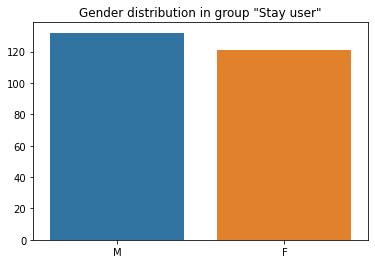

In [44]:
sns.barplot(['M','F'], [df_ubc.select('Gender').where((df_ubc.Gender =='M') & (df_ubc.y ==1)).count(),df_ubc.select('Gender').where((df_ubc.Gender =='F') & (df_ubc.y ==1)).count()])
plt.title('Gender distribution in group "Stay user"')

Text(0.5, 1.0, 'Gender distribution in group "Churn user"')

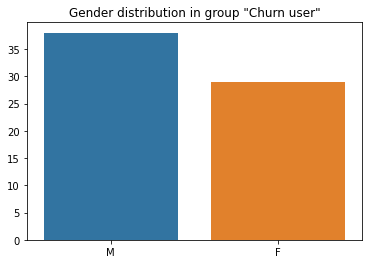

In [45]:
sns.barplot(['M','F'], [df_ubc.select('Gender').where((df_ubc.Gender =='M') & (df_ubc.y ==0)).count(),df_ubc.select('Gender').where((df_ubc.Gender =='F') & (df_ubc.y ==0)).count()])
plt.title('Gender distribution in group "Churn user"')

### 3.2.2 `Device`

Text(0.5, 1.0, 'Device distribution in group "Stay user"')

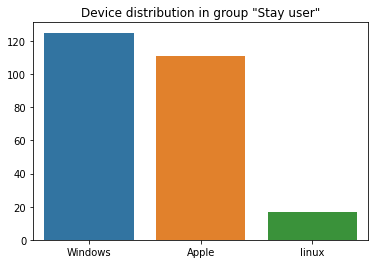

In [46]:
sns.barplot(['Windows','Apple','linux'], [df_ubc.select('Device').where((df_ubc.Device =='w') & (df_ubc.y ==1)).count(), \
                                         df_ubc.select('Device').where((df_ubc.Device =='m') & (df_ubc.y ==1)).count(),\
                                         df_ubc.select('Device').where((df_ubc.Device =='l') & (df_ubc.y ==1)).count()])
plt.title('Device distribution in group "Stay user"')

Text(0.5, 1.0, 'Device distribution in group "Churn user"')

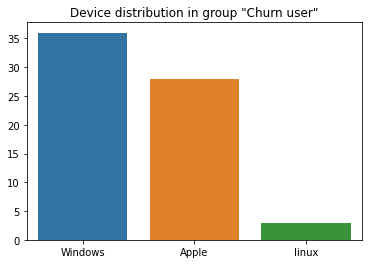

In [47]:
sns.barplot(['Windows','Apple','linux'], [df_ubc.select('Device').where((df_ubc.Device =='w') & (df_ubc.y ==0)).count(), \
                                         df_ubc.select('Device').where((df_ubc.Device =='m') & (df_ubc.y ==0)).count(),\
                                         df_ubc.select('Device').where((df_ubc.Device =='l') & (df_ubc.y ==0)).count()])
plt.title('Device distribution in group "Churn user"')

### 3.3.3 `PlayedTime`

In [48]:
df_ubc = df_ubc.fillna(0)

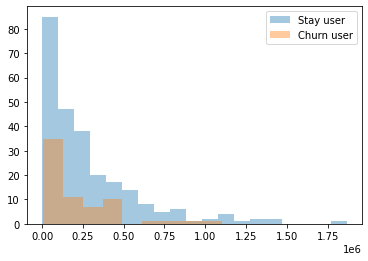

In [49]:
# there is a None in the list, replace it with 0

sns.distplot( [pt.PlayedTime for pt in df_ubc.select('PlayedTime').where(df_ubc.y == 1).collect()], label="Stay user",kde = False)
sns.distplot( [pt.PlayedTime for pt in df_ubc.select('PlayedTime').where(df_ubc.y == 0).collect()], label="Churn user",kde = False)
plt.legend()

### 3.3.4 `PaidTime`

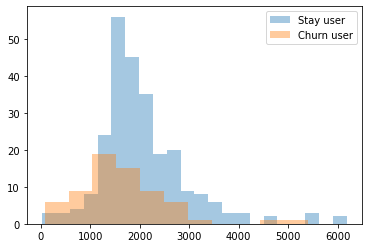

In [50]:
sns.distplot( [pt.PaidTime for pt in df_ubc.select('PaidTime').where(df_ubc.y == 1).collect()], label="Stay user",kde = False)
sns.distplot( [pt.PaidTime for pt in df_ubc.select('PaidTime').where(df_ubc.y == 0).collect()], label="Churn user",kde = False)
plt.legend()

### 3.3.5 `PlayedNumber`

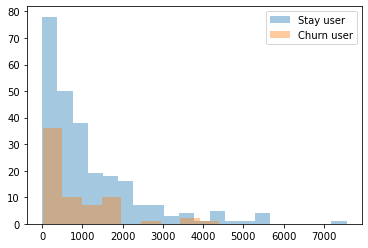

In [51]:
sns.distplot( [pt.PlayNumber for pt in df_ubc.select('PlayNumber').where(df_ubc.y == 1).collect()], label="Stay user",kde = False)
sns.distplot( [pt.PlayNumber for pt in df_ubc.select('PlayNumber').where(df_ubc.y == 0).collect()], label="Churn user",kde = False)
plt.legend()

### 3.3.6 PovEva

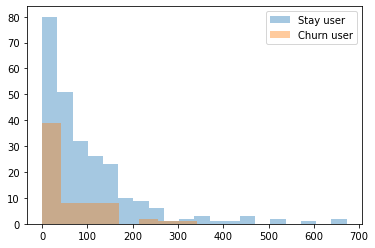

In [52]:
sns.distplot( [pt.PosEva for pt in df_ubc.select('PosEva').where(df_ubc.y == 1).collect()], label="Stay user",kde = False)
sns.distplot( [pt.PosEva for pt in df_ubc.select('PosEva').where(df_ubc.y == 0).collect()], label="Churn user",kde = False)
plt.legend()

### 3.3.7 NegEva

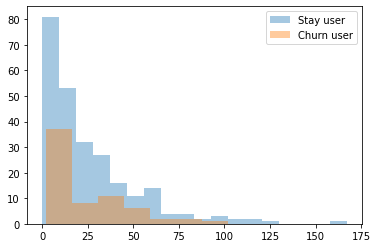

In [53]:
sns.distplot( [pt.NegEva for pt in df_ubc.select('NegEva').where(df_ubc.y == 1).collect()], label="Stay user",kde = False)
sns.distplot( [pt.NegEva for pt in df_ubc.select('NegEva').where(df_ubc.y == 0).collect()], label="Churn user",kde = False)
plt.legend()

# 4. Modeling

#### manuel one hot encoder

In [54]:
# man column
functionf = udf(lambda x: 1 if x == 'M' else 0)
df_ubc = df_ubc.withColumn('Gender_m', functionf(F.col('Gender')))

# woman column
functionf = udf(lambda x: 1 if x == 'F' else 0)
df_ubc = df_ubc.withColumn('Gender_f', functionf(F.col('Gender')))

# remove column gender
df_ubc = df_ubc.drop('Gender')

In [55]:
# w column
functionf = udf(lambda x: 1 if x == 'w' else 0)
df_ubc = df_ubc.withColumn('Device_w', functionf(F.col('Device')))

# a column
functionf = udf(lambda x: 1 if x == 'm' else 0)
df_ubc = df_ubc.withColumn('Device_m', functionf(F.col('Device')))

# l column
functionf = udf(lambda x: 1 if x == 'l' else 0)
df_ubc = df_ubc.withColumn('Device_l', functionf(F.col('Device')))

# remove column gender
df_ubc = df_ubc.drop('Device')

In [56]:
# convert column type

df_ubc = df_ubc.withColumn("userId", df_ubc["userId"].cast(IntegerType()))
df_ubc = df_ubc.withColumn("Gender_m", df_ubc["Gender_m"].cast(IntegerType()))
df_ubc = df_ubc.withColumn("Gender_f", df_ubc["Gender_f"].cast(IntegerType()))
df_ubc = df_ubc.withColumn("Device_w", df_ubc["Device_w"].cast(IntegerType()))
df_ubc = df_ubc.withColumn("Device_m", df_ubc["Device_m"].cast(IntegerType()))
df_ubc = df_ubc.withColumn("Device_l", df_ubc["Device_l"].cast(IntegerType()))

In [57]:
df_ubc.show()

+------+----------+--------+----------+------+------+---+--------+--------+--------+--------+--------+
|userId|PlayedTime|PaidTime|PlayNumber|PosEva|NegEva|  y|Gender_m|Gender_f|Device_w|Device_m|Device_l|
+------+----------+--------+----------+------+------+---+--------+--------+--------+--------+--------+
|200002|     37671|    1279|       143|    10|     7|  0|       1|       0|       0|       1|       0|
|   296|      9351|     639|        36|     3|     2|  0|       0|       1|       0|       1|       0|
|   124|    456664|    2701|      1826|   147|    38|  0|       0|       1|       0|       1|       0|
|    51|     66817|     452|       266|    24|     7|  0|       1|       0|       1|       0|       0|
|   205|    263650|    1249|      1048|    75|    20|  1|       0|       1|       0|       1|       0|
|   282|    564720|    1864|      2259|   173|    47|  1|       1|       0|       1|       0|       0|
|   232|    332766|    2568|      1354|   109|    29|  1|       0|       

In [58]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler,VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rest, validation = df_ubc.randomSplit([0.7, 0.3], seed=42)


input_col = ['userId','PlayedTime','PaidTime','PlayNumber','PosEva','NegEva','Gender_m','Gender_f','Device_w','Device_m','Device_l']
vecAssembler = VectorAssembler(inputCols=input_col, outputCol= "features")
stringIndexer = StringIndexer(inputCol="y", outputCol="label")

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[vecAssembler,stringIndexer,lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cvModel_q1 = crossval.fit(rest)
predict_df = cvModel_q1.transform(validation)


In [59]:
cvModel_q1.avgMetrics

[0.650950226244344, 0.6132431228901818]

In [60]:
results = cvModel_q1.transform(validation)

In [61]:
print(results.filter(results.label == results.prediction).count() / results.count())

0.8584905660377359
